In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'your_kaggle_username'
os.environ['KAGGLE_KEY']      = 'you_kaggle_key'

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [12]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn import datasets
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import spearmanr
from sklearn.impute import SimpleImputer

api = KaggleApi()
api.authenticate()

api.competition_download_file('titanic', 'train.csv', path='.', force=True)
api.competition_download_file('titanic', 'test.csv',  path='.', force=True)

import pandas as pd
train_data = pd.read_csv('train.csv')
test_data  = pd.read_csv('test.csv')

train_data.head()


100%|██████████| 59.8k/59.8k [00:00<00:00, 59.1MB/s]

100%|██████████| 28.0k/28.0k [00:00<00:00, 29.2MB/s]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [16]:
# Classify variables into types based on their data type
classification = []

for column in train_data.columns:
    dtype = train_data[column].dtype
    if dtype == 'int64' or dtype == 'float64':
        # Check if column is numeric or boolean based on unique values
        unique_vals = train_data[column].dropna().unique()
        if len(unique_vals) <= 2:
            var_type = 'Boolean'
        else:
            var_type = 'Numeric'
    elif dtype == 'object':
        # Treat object type as categorical or ordinal based on context
        if 'Qual' in column or 'Cond' in column or 'Type' in column or 'Finish' in column:
            var_type = 'Ordinal'
        else:
            var_type = 'Category'
    else:
        var_type = 'Others'
    classification.append((column, var_type))

# Convert classification list to a DataFrame for better visualization
classification_df = pd.DataFrame(classification, columns=['Variable', 'Type'])

# Display the classification results without using tools
print(classification_df.head(20))  # Display first 20 rows for preview

classification_df.to_csv("classification_df.csv", index=False)



       Variable      Type
0   PassengerId   Numeric
1      Survived   Boolean
2        Pclass   Numeric
3          Name  Category
4           Sex  Category
5           Age   Numeric
6         SibSp   Numeric
7         Parch   Numeric
8        Ticket  Category
9          Fare   Numeric
10        Cabin  Category
11     Embarked  Category


In [17]:
row_count = len(train_data)
print(f"Number of rows: {row_count}")

Number of rows: 891


In [18]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train_desc = train_data.describe()
train_desc

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [451]:
test_desc = test_data.describe()
test_desc

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Missing Data Summary:
          Missing Count  Missing Percentage (%)
Age                 177               19.865320
Cabin               687               77.104377
Embarked              2                0.224467


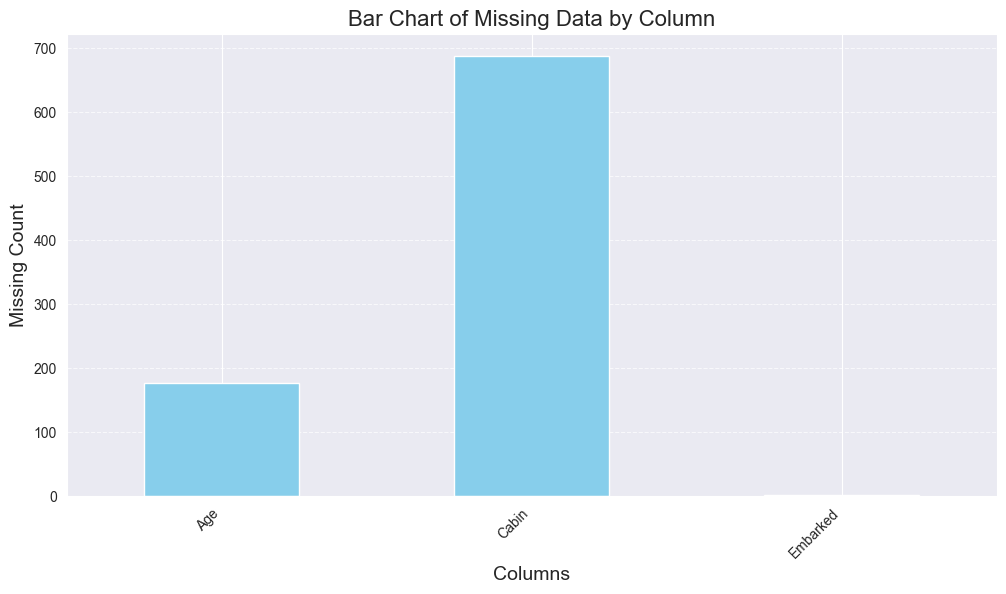


Outlier Summary:
       Outlier Count
Age               11
SibSp             46
Parch            213
Fare             116


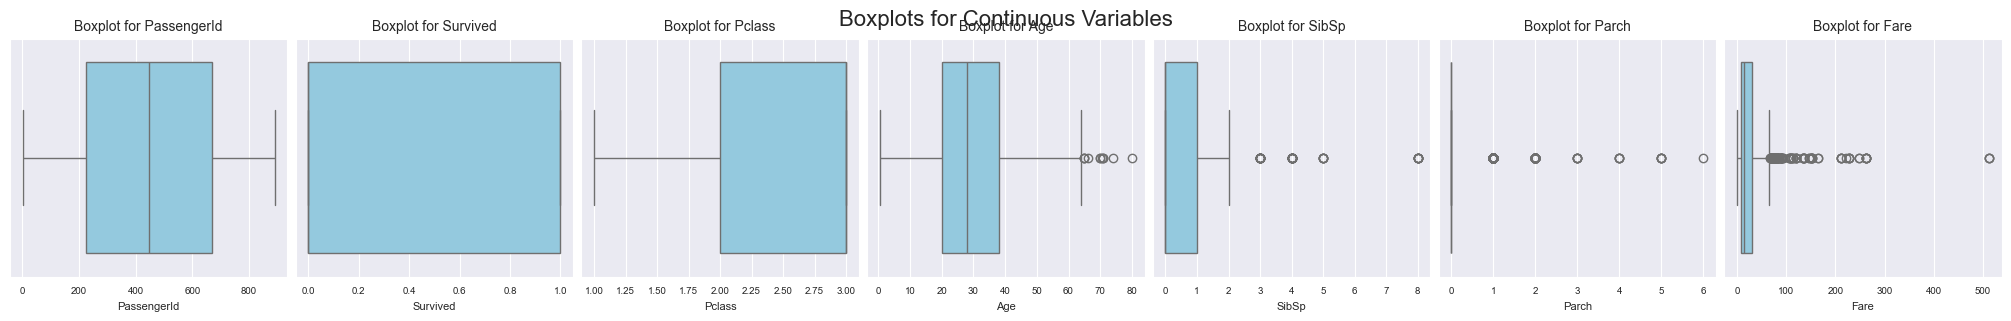

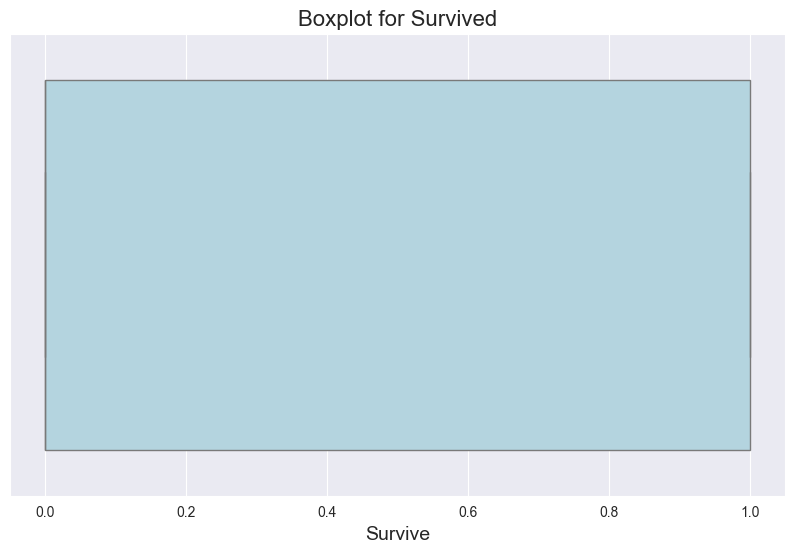

Missing Value Summary:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [452]:
### THIS SESSSION INVESTIGATES TRAIN DATA ###

### Step 1: Investigate Missing Values ###

# Calculate missing values for each column
missing_data = train_data.isnull().sum()
missing_percentage = (missing_data / len(train_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

### Step 2: Investigate Outliers ###

# Use boxplots to identify outliers for continuous variables
continuous_columns = train_data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns

# Detect outliers using the IQR method
outlier_summary = {}
for column in continuous_columns:
    Q1 = train_data[column].quantile(0.25)
    Q3 = train_data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = train_data[(train_data[column] < lower_bound) | (train_data[column] > upper_bound)]
    outlier_count = len(outliers)
    outlier_summary[column] = outlier_count

# Display the outlier summary
outlier_summary_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
outlier_summary_df = outlier_summary_df[outlier_summary_df['Outlier Count'] > 0]  # Filter columns with outliers
print("\nOutlier Summary:")
print(outlier_summary_df)


def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    """
    Plot boxplots for all numeric columns in a DataFrame in a grid layout.

    Parameters:
        data (pd.DataFrame): The DataFrame containing the data.
        max_rows (int): The maximum number of rows in the grid.
        max_cols (int): The maximum number of boxplots per row.
    """
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(train_data)

### Optional: Visualize Outliers in 'SalePrice' ###
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_data['Survived'], color='lightblue')
plt.title("Boxplot for Survived", fontsize=16)
plt.xlabel("Survive", fontsize=14)
plt.show()


### NEW Pre-processing  ###

# Verify if missing values are handled
missing_values_summary = train_data.isnull().sum()

# Separate numerical and categorical columns
numerical_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = train_data.select_dtypes(include=['object','category']).columns

# Impute missing values for numerical columns with the mean
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].mean())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

# Verify if missing values are handled
missing_values_summary = train_data.isnull().sum()

pd.set_option('display.max_rows', None)  # Show all rows
print('Missing Value Summary:')
print(missing_values_summary)

# Display a summary of the dataset using the describe() method
data_description = train_data.describe()

# Show the summary statistics
data_description

Missing Data Summary:
       Missing Count  Missing Percentage (%)
Age               86               20.574163
Fare               1                0.239234
Cabin            327               78.229665


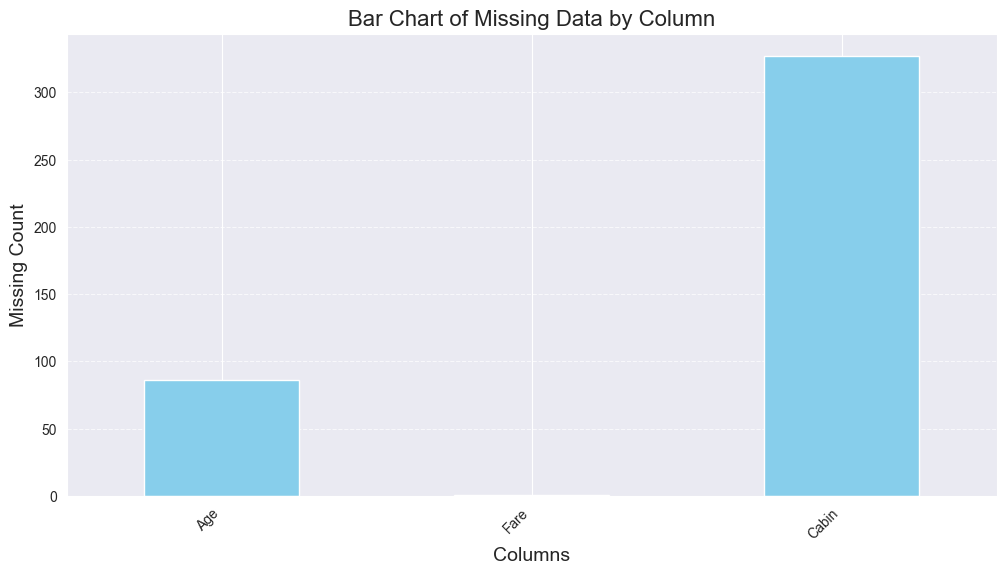

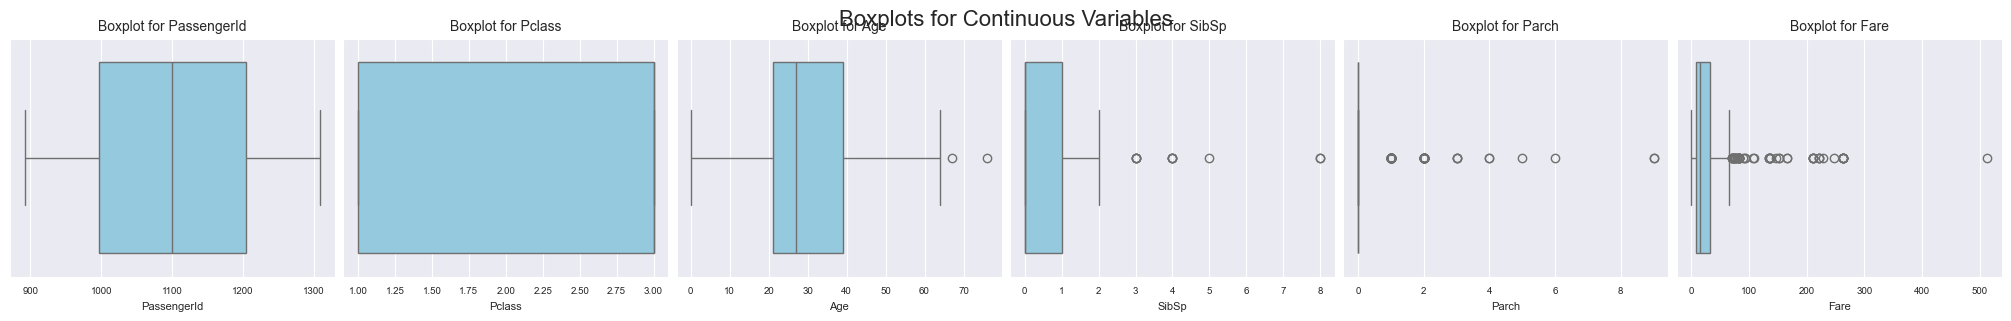

Rows with infinite values:
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
Missing Value Summary:
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch      

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,12.634534,0.896760,0.981429,55.840500
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,23.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,30.272590,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,35.750000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [453]:
### THIS SESSION INVESTIGATES TEST DATA ###

### Step 1: Investigate Missing Values ###
# Calculate missing values for each column
missing_data = test_data.isnull().sum()
missing_percentage = (missing_data / len(test_data)) * 100

# Combine the results in a DataFrame
missing_summary = pd.DataFrame({'Missing Count': missing_data, 'Missing Percentage (%)': missing_percentage})
missing_summary = missing_summary[missing_summary['Missing Count'] > 0]  # Filter columns with missing values
print("Missing Data Summary:")
print(missing_summary)

# Check if there are missing values to visualize
if not missing_summary.empty:
    # Visualize missing data using a bar chart
    plt.figure(figsize=(12, 6))
    missing_summary['Missing Count'].plot(kind='bar', color='skyblue')
    plt.title("Bar Chart of Missing Data by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=14)
    plt.ylabel("Missing Count", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing data found in the dataset.")

def plot_all_boxplots_in_grid(data, max_rows=8, max_cols=10):
    continuous_columns = data.select_dtypes(include=[np.number]).columns.tolist()  # Select numeric columns
    num_plots = len(continuous_columns)
    
    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)  # Number of columns should not exceed the number of plots or max_cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes for easy indexing

    for i, column in enumerate(continuous_columns):
        sns.boxplot(x=data[column], color='skyblue', ax=axes[i])
        axes[i].set_title(f"Boxplot for {column}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(continuous_columns), len(axes)):
        axes[i].axis('off')

    plt.suptitle("Boxplots for Continuous Variables", fontsize=16, y=1.02)
    plt.show()

# Call the function to plot all boxplots in a grid
plot_all_boxplots_in_grid(test_data)



# Capture rows with infinite values
rows_with_infinity = test_data[(test_data == float('inf')).any(axis=1) | (test_data == -float('inf')).any(axis=1)]
print("Rows with infinite values:")
print(rows_with_infinity)

# Replace infinite values with NaN
test_data.replace([float('inf'), -float('inf')], float('nan'), inplace=True)


# Check # of row
print(test_data.info())


## New Pre-processing ###

# Separate numerical and categorical columns
numerical_columns = test_data.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = test_data.select_dtypes(include=['object','category']).columns

# Impute missing values for numerical columns with the mean
test_data[numerical_columns] = test_data[numerical_columns].fillna(test_data[numerical_columns].mean())

# Impute missing values for categorical columns with the mode
for col in categorical_columns:
    test_data[col] = test_data[col].fillna(test_data[col].mode()[0])

# Verify if missing values are handled
missing_values_summary = test_data.isnull().sum()

pd.set_option('display.max_rows', None)  # Show all rows
print('Missing Value Summary:')
print(missing_values_summary)

# Display a summary of the dataset using the describe() method
data_description = test_data.describe()

# Show the summary statistics
data_description


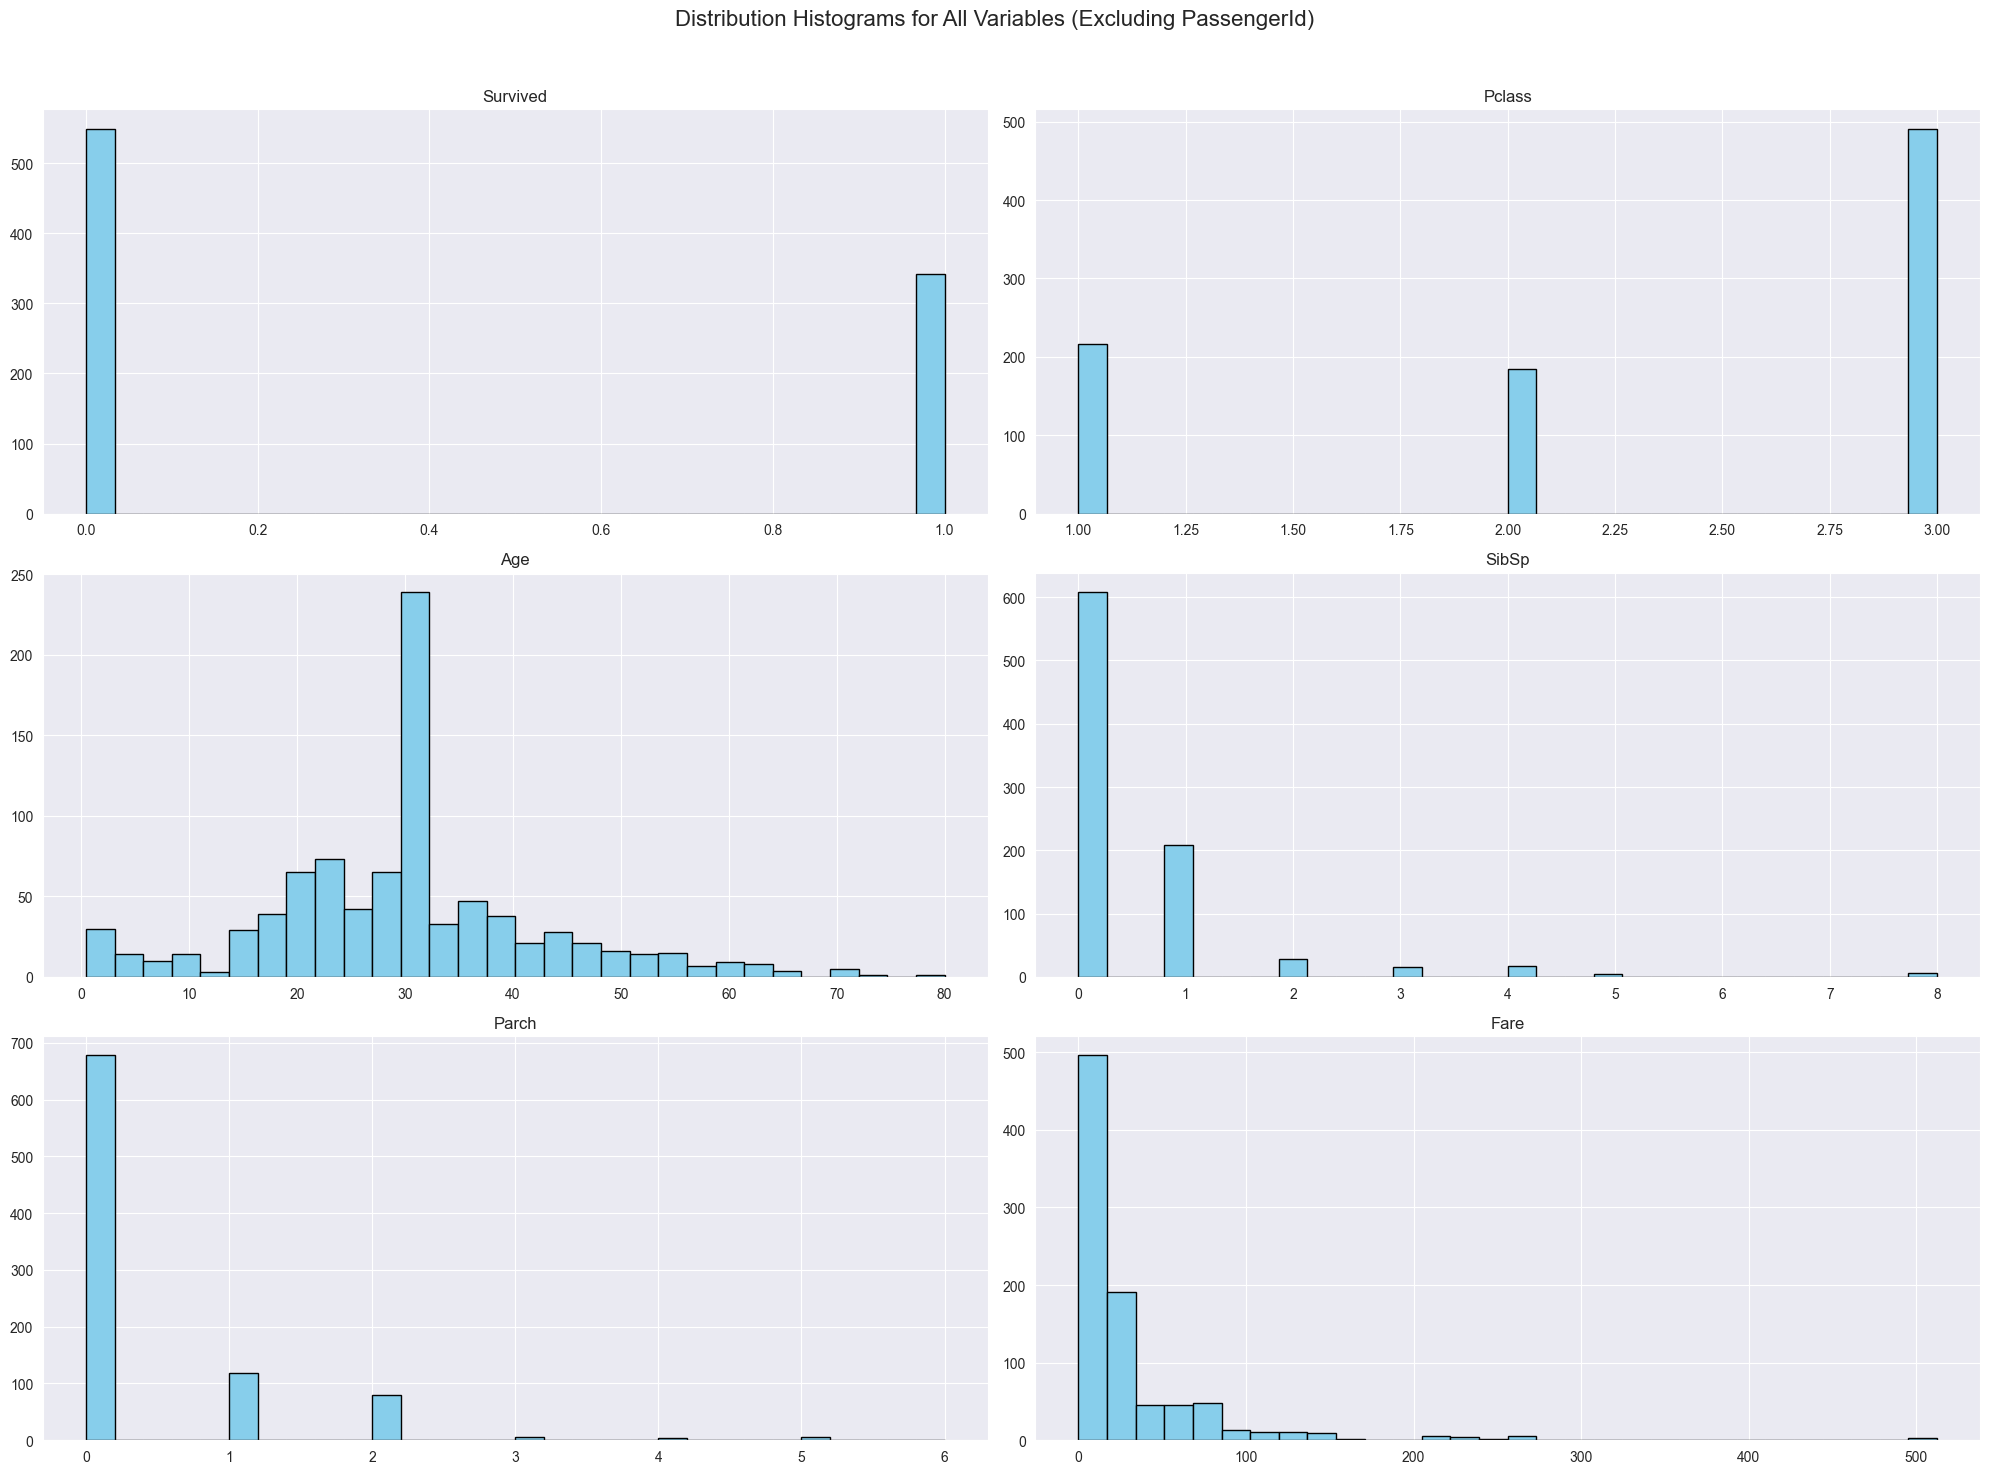

In [454]:
# Exclude "Survived" from the dataset before plotting histograms
train_data.drop(columns=['PassengerId']).hist(figsize=(20, 15), bins=30, color='skyblue', edgecolor='black')

plt.suptitle('Distribution Histograms for All Variables (Excluding PassengerId)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [455]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


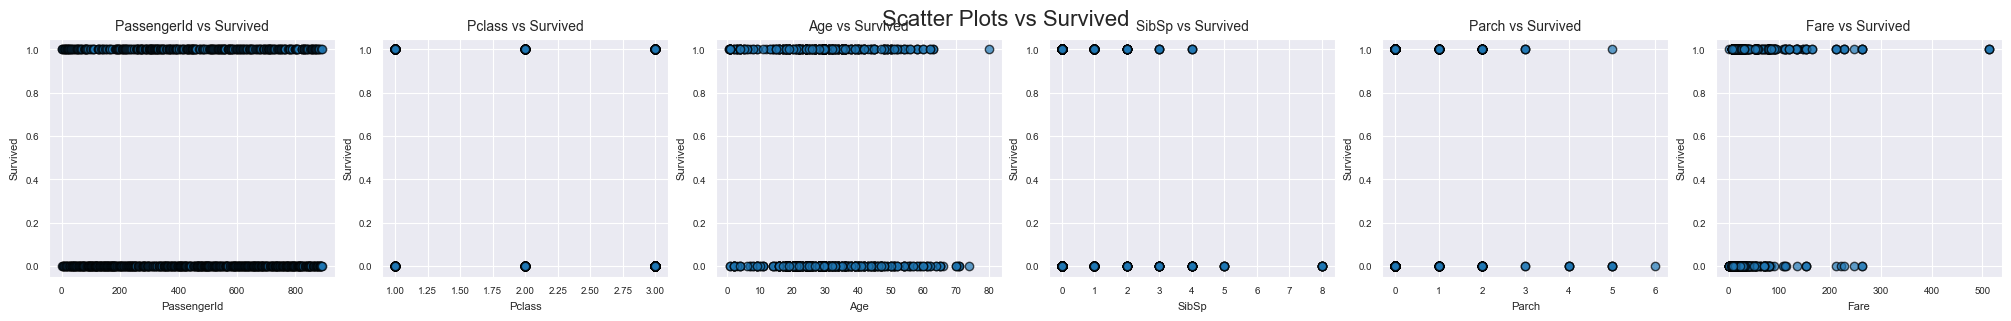

In [456]:
## Analyze collinearity with scatter plots ###

import matplotlib.pyplot as plt

def scatter_plots_with_target(data, target, max_rows=8, max_cols=10):

    # Select numeric columns and exclude the target variable
    numeric_columns = data.select_dtypes(include=[np.number]).columns.drop(target)
    num_plots = len(numeric_columns)

    # Determine grid dimensions
    rows = min(max_rows, -(-num_plots // max_cols))  # Ceiling division for number of rows
    cols = min(max_cols, num_plots)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 3), constrained_layout=True)
    axes = axes.flatten()  # Flatten the axes for easy indexing

    # Loop through each numeric column and create scatter plots
    for i, column in enumerate(numeric_columns):
        axes[i].scatter(data[column], data[target], alpha=0.7, edgecolor='k')
        axes[i].set_title(f"{column} vs {target}", fontsize=10)
        axes[i].set_xlabel(column, fontsize=8)
        axes[i].set_ylabel(target, fontsize=8)
        axes[i].tick_params(axis='x', labelsize=7)
        axes[i].tick_params(axis='y', labelsize=7)

    # Hide unused subplots
    for i in range(len(numeric_columns), len(axes)):
        axes[i].axis('off')

    # Display the plots
    plt.suptitle(f"Scatter Plots vs {target}", fontsize=16, y=1.02)
    plt.show()

# Example usage with train_data_filtered
scatter_plots_with_target(train_data, target="Survived", max_rows=8, max_cols=10)


In [457]:
## Select a smaller set of variables ###

subdat = train_data[["Pclass", "Sex","Age", "SibSp", "Parch", "Fare","Embarked"]]


In [458]:
subdat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   Age       891 non-null    float64
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
 6   Embarked  891 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 48.9+ KB


In [459]:
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
numeric_columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

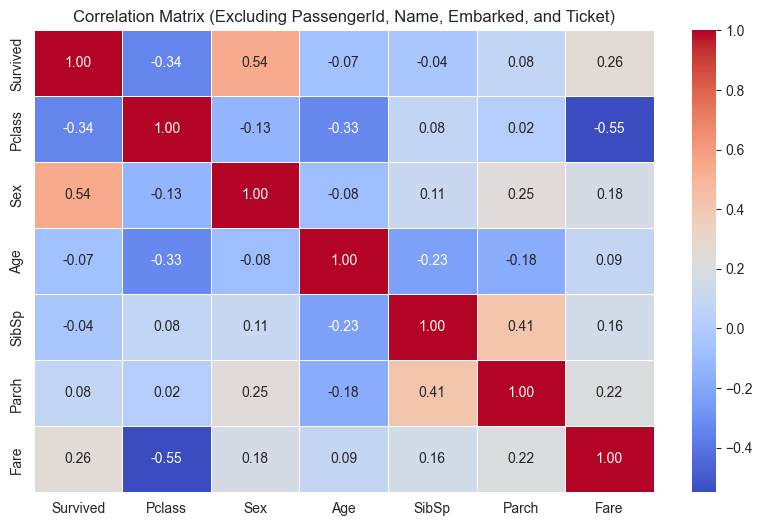

In [461]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_data is already loaded

# Drop unnecessary columns (PassengerId, Name, Embarked, and Ticket)
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Embarked', 'Ticket'], errors='ignore')

# Convert categorical variables to numeric
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})

# Ensure only numeric columns are used for correlation
numeric_train_data = train_data.select_dtypes(include=['number'])

# Compute correlation matrix
corr_matrix = numeric_train_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Excluding PassengerId, Name, Embarked, and Ticket)")
plt.show()


In [427]:

# # Perform dummy coding for specified columns
# columns_to_dummy = ["Sex", "Embarked"]
#
# # Create dummy variables
# data_dummies = pd.get_dummies(train_data, columns=columns_to_dummy, drop_first=True, dtype=int)
#
# # Display the first few rows of the transformed dataset
# data_dummies.describe()

# Replaces the original columns in `train_data` with the ones from `data_dummies`, while keeping all other columns

In [428]:
# from sklearn.model_selection import train_test_split
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# import pandas as pd
#
# # Exclude "Survived" from X and keep only numeric columns
# X_numeric = train_data.drop(columns=['Survived']).select_dtypes(include=['float64', 'int64', 'int32', 'uint8', 'int8'])
#
# # Declare y as "Survived"
# y = train_data['Survived']
#
# # Standard Scaling
# standard_scaler = StandardScaler()
# X_standard_scaled = pd.DataFrame(
#     standard_scaler.fit_transform(X_numeric), columns=X_numeric.columns
# )
#
# # Min-Max Scaling
# minmax_scaler = MinMaxScaler()
# X_minmax_scaled = pd.DataFrame(
#     minmax_scaler.fit_transform(X_numeric), columns=X_numeric.columns
# )
#
# # Display results for comparison
# X_minmax_scaled.head(),X_standard_scaled

In [429]:
# # Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X_minmax_scaled, y, test_size=0.2, random_state=42)
#
# # Display processed data information
# X_train.head(), y_train.head()

### Model Performance Evaluation ###

Confusion Matrix:
[[473  76]
 [102 240]]

Goodness-of-Fit Metrics:
- Accuracy: 80.0%
- Precision: 75.9%
- Recall: 70.2%
- F1 Score: 72.9%
- ROC AUC: 85.8%


C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\1565643824.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\1565643824.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

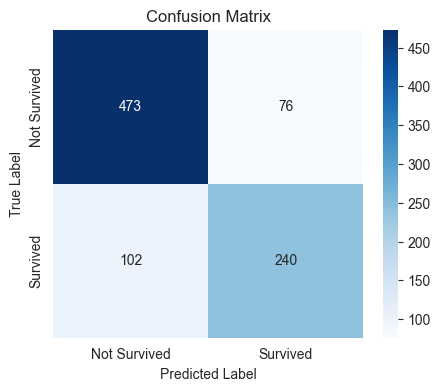

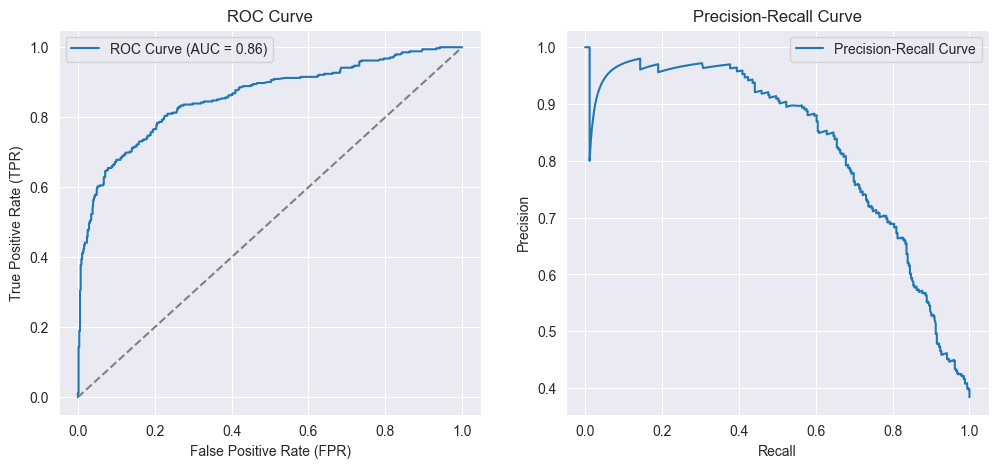

Submission saved to 'logistic_submission.csv'


In [430]:
### Logistic Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score
)


# Drop unnecessary columns
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Handle missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# Encode categorical variables
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding for 'Embarked'
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display processed data structure
X[:5]

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize logistic regression model
log_reg = LogisticRegression(max_iter=500)

# Evaluate model using cross-validation
cv_scores = cross_val_score(log_reg, X_scaled, Y, cv=kf, scoring='accuracy')

# Display cross-validation scores
cv_mean_accuracy = np.mean(cv_scores)
cv_scores, cv_mean_accuracy

# Train the logistic regression model
log_reg.fit(X_scaled, Y)

# Predict on the training set
Y_pred = log_reg.predict(X_scaled)
Y_prob = log_reg.predict_proba(X_scaled)[:, 1]  # Probabilities for ROC curve

# Compute confusion matrix
conf_matrix = confusion_matrix(Y, Y_pred)

# Calculate performance metrics
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
f1 = f1_score(Y, Y_pred)
roc_auc = roc_auc_score(Y, Y_prob)

# Store results in a dictionary
model_evaluation = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc
}

# Print Confusion Matrix and Evaluation Metrics
print("### Model Performance Evaluation ###\n")
print("Confusion Matrix:")
print(conf_matrix)

print("\nGoodness-of-Fit Metrics:")
for metric, value in model_evaluation.items():
    print(f"- {metric}: {value * 100:.1f}%")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Compute ROC curve
fpr, tpr, _ = roc_curve(Y, Y_prob)

# Compute Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(Y, Y_prob)

# Plot ROC Curve
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Show plots
plt.show()

# # Keep only the necessary features (same as train data)
# test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
#
# # Handle missing values
# test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
# test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
# test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)
#
# # Encode categorical variables (Sex and Embarked)
# test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})
#
# # One-hot encoding for 'Embarked' (Ensure same structure as train data)
# test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

# Ensure test data has the same columns as train data
missing_cols = set(X.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  # Add missing column if not present

# Standardize numeric features using the same scaler from training
X_test_scaled = scaler.transform(test_data)

# Predict survival
test_predictions = log_reg.predict(X_test_scaled)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/test.csv", header=0, sep=",")

final_submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],  # Ensure PassengerId is included
    "Survived": test_results["Survived"]  # Add Survived predictions
})

# Save to CSV
final_submission.to_csv("logistic_submission.csv", index=False)
print("Submission saved to 'logistic_submission.csv'")





In [431]:
print(test_results)

     Survived
0           0
1           0
2           0
3           0
4           1
5           0
6           1
7           0
8           1
9           0
10          0
11          0
12          1
13          0
14          1
15          1
16          0
17          0
18          1
19          1
20          0
21          0
22          1
23          1
24          1
25          0
26          1
27          0
28          0
29          0
30          0
31          0
32          0
33          0
34          1
35          0
36          1
37          1
38          0
39          0
40          0
41          0
42          0
43          1
44          1
45          0
46          0
47          0
48          1
49          0
50          0
51          0
52          1
53          1
54          0
55          0
56          0
57          0
58          0
59          1
60          0
61          0
62          0
63          1
64          1
65          1
66          1
67          0
68          1
69          1
70    

Cross-Validation Accuracy: 0.7946

### Model Performance Evaluation ###

Confusion Matrix:
[[470  79]
 [102 240]]

Goodness-of-Fit Metrics:
- Accuracy: 79.69%
- Precision: 75.24%
- Recall: 70.18%
- F1 Score: 72.62%
- ROC AUC: 85.56%


C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\502094322.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\502094322.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

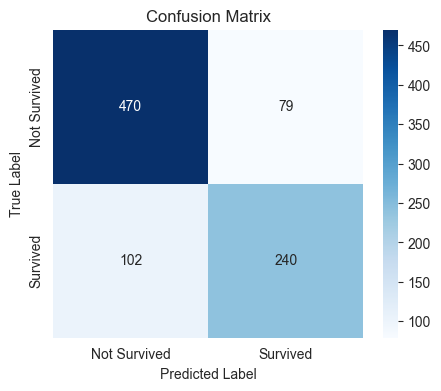

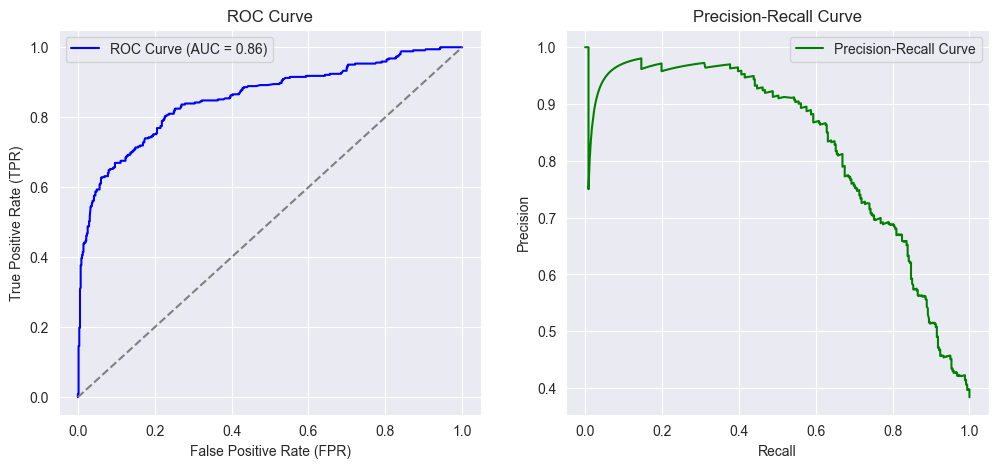

In [432]:
## LDA Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score
)

train_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/train.csv", header=0, sep=",")
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/test.csv", header=0, sep=",")

# Drop unnecessary columns
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Handle missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# Encode categorical variables
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding for 'Embarked'
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize LDA model
lda_model = LinearDiscriminantAnalysis()

# Evaluate model using cross-validation
cv_scores = cross_val_score(lda_model, X_scaled, Y, cv=kf, scoring='accuracy')

# Display cross-validation scores
cv_mean_accuracy = np.mean(cv_scores)
print(f"Cross-Validation Accuracy: {cv_mean_accuracy:.4f}")

# Train the LDA model
lda_model.fit(X_scaled, Y)

# Predict on the training set
Y_pred = lda_model.predict(X_scaled)
Y_prob = lda_model.predict_proba(X_scaled)[:, 1]  # Probabilities for ROC curve

# Compute confusion matrix
conf_matrix = confusion_matrix(Y, Y_pred)

# Calculate performance metrics
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
f1 = f1_score(Y, Y_pred)
roc_auc = roc_auc_score(Y, Y_prob)

# Store results in a dictionary
model_evaluation = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc
}

# Print Confusion Matrix and Evaluation Metrics
print("\n### Model Performance Evaluation ###\n")
print("Confusion Matrix:")
print(conf_matrix)

print("\nGoodness-of-Fit Metrics:")
for metric, value in model_evaluation.items():
    print(f"- {metric}: {value * 100:.2f}%")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve
fpr, tpr, _ = roc_curve(Y, Y_prob)

# Compute Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(Y, Y_prob)

# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Show plots
plt.show()

# Ensure test data has the same columns as train data
missing_cols = set(X.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  # Add missing column if not present

# Standardize numeric features using the same scaler from training
X_test_scaled = scaler.transform(test_data)

# Predict survival using LDA
test_predictions = lda_model.predict(X_test_scaled)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Retrieve PassengerId and create final submission table
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/test.csv", header=0, sep=",")
final_submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": test_results["Survived"]
})

# Save predictions as CSV file
csv_filename = "lda_titanic_predictions.csv"
final_submission.to_csv(csv_filename, index=False)




Cross-Validation Accuracy: 0.8103

### Model Performance Evaluation ###

Confusion Matrix:
[[497  52]
 [ 76 266]]

Goodness-of-Fit Metrics:
- Accuracy: 85.63%
- Precision: 83.65%
- Recall: 77.78%
- F1 Score: 80.61%
- ROC AUC: 93.08%


C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\173506205.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
C:\Users\pgper\AppData\Local\Temp\ipykernel_26688\173506205.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

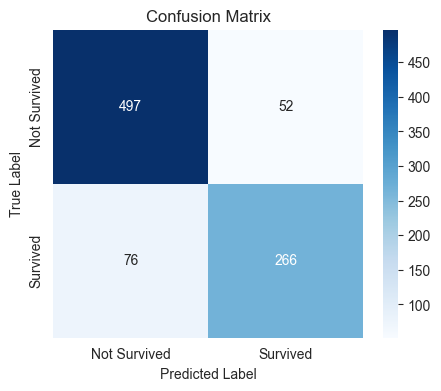

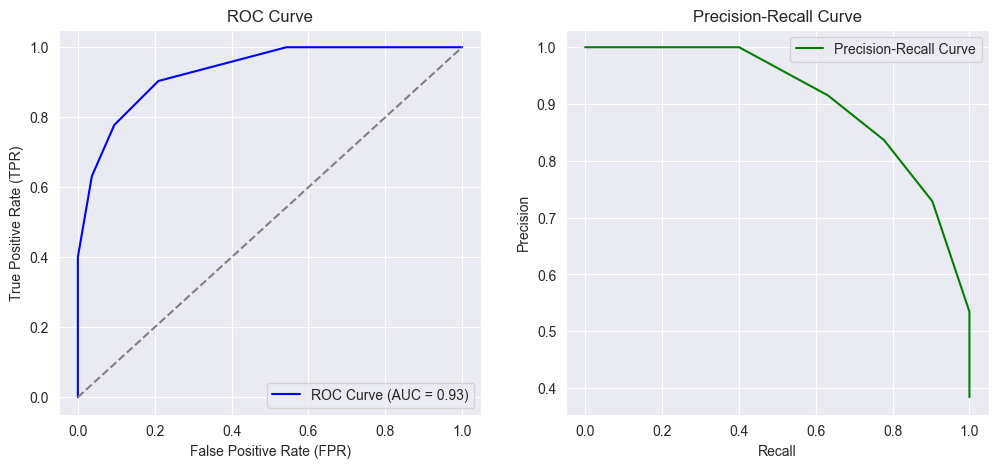

In [433]:
### KNN Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve,
    precision_recall_curve, f1_score
)

# Load datasets
train_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/train.csv", header=0, sep=",")
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/test.csv", header=0, sep=",")

# Drop unnecessary columns
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# Handle missing values
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
train_data['Embarked'].fillna(train_data['Embarked'].mode()[0], inplace=True)

test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].median(), inplace=True)
test_data['Embarked'].fillna(test_data['Embarked'].mode()[0], inplace=True)

# Encode categorical variables
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

# One-hot encoding for 'Embarked'
train_data = pd.get_dummies(train_data, columns=['Embarked'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['Embarked'], drop_first=True)

# Define X and Y
X = train_data.drop(columns=['Survived'])
Y = train_data['Survived']

# Standardize numeric features (Important for KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize KNN model (Choosing k=5 as a starting point)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Evaluate model using cross-validation
cv_scores = cross_val_score(knn_model, X_scaled, Y, cv=kf, scoring='accuracy')

# Display cross-validation scores
cv_mean_accuracy = np.mean(cv_scores)
print(f"Cross-Validation Accuracy: {cv_mean_accuracy:.4f}")

# Train the KNN model
knn_model.fit(X_scaled, Y)

# Predict on the training set
Y_pred = knn_model.predict(X_scaled)
Y_prob = knn_model.predict_proba(X_scaled)[:, 1]  # Probabilities for ROC curve

# Compute confusion matrix
conf_matrix = confusion_matrix(Y, Y_pred)

# Calculate performance metrics
accuracy = accuracy_score(Y, Y_pred)
precision = precision_score(Y, Y_pred)
recall = recall_score(Y, Y_pred)
f1 = f1_score(Y, Y_pred)
roc_auc = roc_auc_score(Y, Y_prob)

# Store results in a dictionary
model_evaluation = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc
}

# Print Confusion Matrix and Evaluation Metrics
print("\n### Model Performance Evaluation ###\n")
print("Confusion Matrix:")
print(conf_matrix)

print("\nGoodness-of-Fit Metrics:")
for metric, value in model_evaluation.items():
    print(f"- {metric}: {value * 100:.2f}%")

# Plot Confusion Matrix as Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Survived", "Survived"],
            yticklabels=["Not Survived", "Survived"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Compute ROC curve
fpr, tpr, _ = roc_curve(Y, Y_prob)

# Compute Precision-Recall curve
precision_vals, recall_vals, _ = precision_recall_curve(Y, Y_prob)

# Plot ROC and Precision-Recall Curves
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color="blue")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Show plots
plt.show()

# Ensure test data has the same columns as train data
missing_cols = set(X.columns) - set(test_data.columns)
for col in missing_cols:
    test_data[col] = 0  # Add missing column if not present

# Standardize numeric features using the same scaler from training
X_test_scaled = scaler.transform(test_data)

# Predict survival using KNN
test_predictions = knn_model.predict(X_test_scaled)

# Store predictions in a DataFrame
test_results = pd.DataFrame({
    "Survived": test_predictions
})

# Retrieve PassengerId and create final submission table
test_data = pd.read_csv("/Users/pgper/Documents/1_MSDS_422_Practical_ML/4_ModelAssignment4/test.csv", header=0, sep=",")
final_submission = pd.DataFrame({
    "PassengerId": test_data["PassengerId"],
    "Survived": test_results["Survived"]
})

# Save predictions as CSV file
csv_filename = "knn_titanic_predictions.csv"
final_submission.to_csv(csv_filename, index=False)



